In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install sentence-transformers
!pip install beautifultable
!pip install termcolor
from termcolor import colored
from beautifultable import BeautifulTable
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
import os, glob
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import pickle
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Multiply, Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from skimage.io import imread
from tensorflow.keras.models import  load_model
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
import gc
collected = gc.collect()
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive
     |████████████████████████████████| 79 kB 6.4 MB/s 
     |████████████████████████████████| 4.0 MB 50.3 MB/s 
     |████████████████████████████████| 1.2 MB 45.1 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 6.6 MB 55.5 MB/s 
     |████████████████████████████████| 596 kB 16.6 MB/s 
     |████████████████████████████████| 895 kB 44.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=db7cb03f172c7c449bdd3958cfa4008e860e5e92b9e973b788165d1ce1fd19c7
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [4]:
# Final Model Prediction function
def final_pred(image_path, question, answer):
  """
  Returns accuracy value for given evaluation data to judge our final model

  Input:
    image_path_list: list of paths where images are stored
    questions_list: list of question texts
    answers_list: list of corresponding answers
    batch_size

  Returns:
    img_tensor : image tensor
    ques: question tensor which comes directly from the pipeline
  """

  # Question text featurization using sbert model
  test_X_seqs = sbert_model.encode(question)
  test_X_seqs = np.expand_dims(test_X_seqs, axis=0)

  # Image featurization using pretrained Xception model
  image_test = np.array([resize(imread(image_path), (299, 299,3))])
  model = tf.keras.applications.Xception(include_top=True,weights='imagenet')
  feature_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
  image_test = feature_model(image_test)

  # Loading pre-trained final model
  final_model = load_model('final_model.h5')

  # loading label ohe
  with open('label_ohe.pickle', 'rb') as handle:
      label_ohe = pickle.load(handle)

  # Model prediction
  predicted_y = final_model.predict([image_test,test_X_seqs])

  # Plotting image, question, top 5 model predicted answers and their probabilities and actual answer
  plt.figure(figsize=(5,5))
  image = imread(image_path)  
  image = resize(image, (1050, 1050))
  plt.imshow(image)
  plt.show()
  print(question)
  print('Actual answer:',answer)
    
  class_indices = tf.math.top_k(predicted_y,k=5).indices.numpy().flatten()
  percentages = tf.math.top_k(predicted_y,k=5).values.numpy()[0] * 100
  predictions = []
  for idx,i in enumerate(class_indices):
      classes = np.zeros((1,626))
      classes[0][i] = 1
      predictions.append((label_ohe.inverse_transform(classes)[0][0],percentages[idx])) 
  print(f"Top Predicted answers: {predictions}")

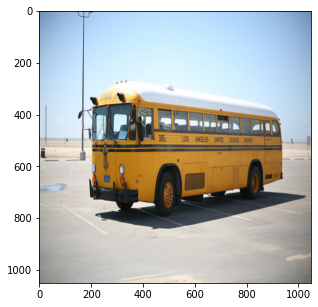

How many busses do you see?
Actual answer: 1
Top Predicted answers: [('1', 40.655388), ('2', 12.190522), ('3', 11.465422), ('5', 7.709017), ('4', 7.2248087)]


In [5]:
# Running predictions function
final_pred('/content/drive/MyDrive/Test_Images/COCO_train2014_000000000471.jpg', 'How many busses do you see?', '1')

In [10]:
# Final Model evaluation function

#********************************************************************************************************************************************#
# Utility functions to be used in final model evaluation function
def parse_function(filename):
    """
    Given image path it returns resized and scaled ([0-1] range)version of the image in preparation for passing to pretrained CNN Models

    Input:
      filename: path of stored image
      img_tensor_model: Pre-trained model to be loaded and used for image vectorization

    Returns:
      image: processed image
      filename: image file path)
	  """
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [299, 299])
    return  image, filename

def map_func(img_path, ques):
    """
    Gets image tensor from stored location
	
    Input:
      img_path: path where image is stored
      ques: question tensor which comes directly from the pipeline

    Returns:
      img_tensor : image tensor
      ques: question tensor which comes directly from the pipeline
	  """
    img_tensor = np.load(img_path.decode('utf-8') + "Xception" + '.npy')
    return img_tensor, ques

#********************************************************************************************************************************************#

def final_eval(image_path_list, questions_list, answers_list,batch_size):
  """
  Returns accuracy value for given evaluation data to judge our final model

  Input:
    image_path_list: list of paths where images are stored
    questions_list: list of question texts
    answers_list: list of corresponding answers
    batch_size

  Returns:
    img_tensor : image tensor
    ques: question tensor which comes directly from the pipeline
  """

  # Convert text and labels to arrays for further processing
  questions = np.array(questions_list)
  answers = np.array(answers_list)

  # Loading pre-trained final model
  final_model = load_model('final_model.h5')

  # loading label ohe
  with open('label_ohe.pickle', 'rb') as handle:
      label_ohe = pickle.load(handle)

  # Text and label featurization
  test_text_sbert = sbert_model.encode(questions)
  answ_vector = label_ohe.transform(answers.reshape(-1,1)).toarray()

  # Image featurization using pretrained Xception model
  model = tf.keras.applications.Xception(include_top=True,weights='imagenet')
  feature_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
  img_data_tr=tf.data.Dataset.from_tensor_slices(image_path_list)
  img_data_tr = img_data_tr.map(lambda img_path: tf.numpy_function(parse_function, [img_path], [tf.float32, tf.string]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  # Storing all image vectors into same path as images
  for img, path in tqdm(img_data_tr):
    batch_features = feature_model(img)
    for bf, p in zip(batch_features, path):
      path_of_feature = p.numpy().decode("utf-8") + "Xception" + '.npy'    
      np.save(path_of_feature, bf.numpy())

  # Generating tf.data.dataset for model evaluation
  dataset_ = tf.data.Dataset.from_tensor_slices((image_path_list, test_text_sbert))
  op_dataset_ = tf.data.Dataset.from_tensor_slices(answ_vector)
  dataset_ = dataset_.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.float32]),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset_=tf.data.Dataset.zip((dataset_,op_dataset_))
  dataset_ = dataset_.batch(batch_size)
  dataset_ = dataset_.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  
  return final_model.evaluate(dataset_)[1]

In [11]:
# Running final model evaluation function

# Inputs for model evaluation
questions_list = ['How many busses do you see?',	
'Is the lens on this camera normal?',
'Is the kite high in the air?',
'Is this plane taking off?',
'How many cookies can be seen?']

image_path_list = ['/content/drive/MyDrive/Test_Images/COCO_train2014_000000000471.jpg',
'/content/drive/MyDrive/Test_Images/COCO_train2014_000000000531.jpg',
'/content/drive/MyDrive/Test_Images/COCO_train2014_000000000149.jpg',
'/content/drive/MyDrive/Test_Images/COCO_train2014_000000000081.jpg',
'/content/drive/MyDrive/Test_Images/COCO_train2014_000000000009.jpg']

answers_list = ['1','yes','yes','no','2']

# Running model evaluation function
acc = final_eval(image_path_list, questions_list, answers_list, 1)
print(f"Accuracy value is: {acc}")

100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


5/5 [==============================] - 0s 5ms/step - loss: 0.9325 - accuracy: 0.6000
Accuracy value is: 0.6000000238418579
